# Loading the dataset from kaggle

In [1]:
from google.colab import files

In [2]:
uploaded=files.upload()

Saving kaggle.json to kaggle.json


In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c llm-detect-ai-generated-text

  0% 0.00/1.38M [00:00<?, ?B/s]
100% 1.38M/1.38M [00:00<00:00, 93.3MB/s]


In [6]:
from zipfile import ZipFile
file_name="llm-detect-ai-generated-text.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Data unzipped')

Data unzipped


# Importing Libraries

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re
import nltk
import seaborn as sns
%matplotlib inline

# Exploratory Data Analysis








In [8]:
train_ds=pd.read_csv("train_essays.csv")
train_ds.shape

(1378, 4)

In [9]:
test_ds=pd.read_csv('test_essays.csv')
test_ds.shape

(3, 3)

In [10]:
train_ds.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [11]:
test_ds.head()

,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


In [12]:

train_ds.iloc[1373]['text']

'There has been a fuss about the Elector College. Many people get confused about how it works and if they\'re satisfied with the whole process. Show we "abolish" the Elector College? Should we keep it? Honestly we should keep it. We the peope have more then enough control on who is chosen for the president of the United States Of America. We don\'t really vote for the president but our vote impacts the decision.\n\nMany citizens of the United States Of America think their vote doesn matter, it does. Why? Well, first the government is runned by the people. Its very rare to not get the president that has the most popular votes, the last time when the president wasn\'t chosen was in 1888. It\'s less likely for the president with the most votes to lose the election. For example, Obama received 61.7 percent of the elector votes compared to only 51.3 percent of the popular votes cast for him and rodney. Plus, almost all states award elector votes on a winnertakeitall basis.\n\nPerhaps, there

In [13]:
train_ds.iloc[1373]['generated']  #generated as 0 indicates text generated by student and 1 indicates generated by LLM.

0

Missing Data

In [14]:
train_ds.isnull()

,id,prompt_id,text,generated
0,False,False,False,False
1,False,False,False,False
2,False,False,False,False
3,False,False,False,False
4,False,False,False,False
...,...,...,...,...
1373,False,False,False,False
1374,False,False,False,False
1375,False,False,False,False
1376,False,False,False,False


<Axes: >

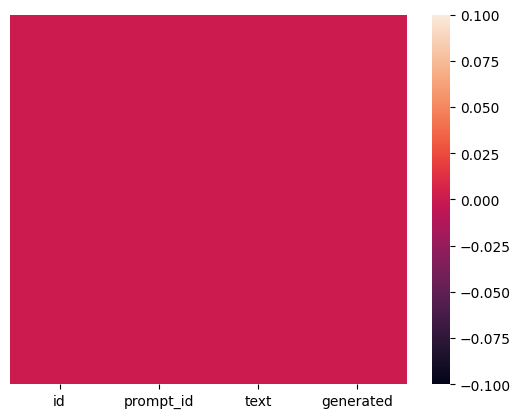

In [15]:
sns.heatmap(train_ds.isnull(),yticklabels=False)    #done to detect null values


<Axes: xlabel='generated', ylabel='count'>

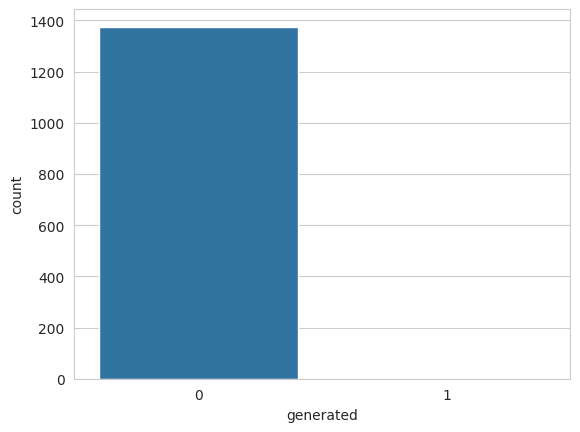

In [16]:
sns.set_style('whitegrid')
sns.countplot(x=train_ds['generated'])

As can be seen above, the difference between student generated and llm generated is huge.

In [121]:
train_ds['generated'].value_counts()

0    1375
1       3
Name: generated, dtype: int64

 708 essays have been written in response to prompt with id 0 and 670 in response to prompt with id 1. Out of all these essays, 1375 are student generated while only 3 are LLM-generated.

In [19]:
import plotly.express as px

Visualising the data imbalance in the form of a pie chart

In [20]:
labels=["Student","LLM"]
student_or_not=train_ds['generated'].value_counts().tolist()
values=[student_or_not[0],student_or_not[1]]
fig=px.pie(values=train_ds['generated'].value_counts(),names=labels,width=500,height=500,color_discrete_sequence=["green","red"],title="Student vs LLM")
fig.show()

The pie chart shows that tha data is highly imbalanced.
As can be seen, 99.8% of the training dataset is student generated and remaining 0.218% is LLM generated



# Handling Imbalanced Dataset

# Adding extra data to handle imbalanced dataset

The idea is to add more data rows where it is LLM generated; generated=1. This is done as a part of oversampling the minority.

In [40]:
ext_data=pd.read_csv("/content/train_drcat_02.csv")
ext_data=ext_data[['text','label']]
ext_data.columns=['text','generated']
ext_data

,text,generated
0,"Okay, here is my essay:\n\nWorking or doing th...",1
1,"Dear Principal,\r\n\r\nI just want to let you ...",0
2,I believe they should change the voting to pop...,0
3,One example of an inspiring individual who has...,1
4,"Dear Mr. Principal,\n\nI believe that students...",0
...,...,...
39780,"""Oh man I didn't make the soccer team!"", yelle...",0
39781,I believe that using this technology could be ...,0
39782,The Face on Mars is a fascinating phenomenon t...,1
39783,Texting & Driving\n\nUsing your phone while dr...,0


In [42]:
data=ext_data[ext_data['generated']==1]
data.head()

,text,generated
0,"Okay, here is my essay:\n\nWorking or doing th...",1
3,One example of an inspiring individual who has...,1
6,"""As a high school student, I have witnessed th...",1
11,Video games have been a popular form of entert...,1
13,Group work is an essential part of life; it ca...,1


Unzipping the new data added.

In [48]:
from zipfile import ZipFile
file_name="/content/archive (3).zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Data unzipped')


Data unzipped


In [105]:

ext_data3=pd.read_csv("/content/train_essays_RDizzl3_seven_v1.csv")
ext_data3.columns=['text','generated']
ext_data3=ext_data1[ext_data1['generated']==0]


Concatenating original dataset provided in kaggle with the external datasets used.

In [106]:
train_data=pd.concat([train_ds,data,ext_data3],axis=0,ignore_index=True)
train_data=train_data[['text','generated']]

In [107]:
train_data

,text,generated
0,Cars. Cars have been around since they became ...,0
1,Transportation is a large necessity in most co...,0
2,"""America's love affair with it's vehicles seem...",0
3,How often do you ride in a car? Do you drive a...,0
4,Cars are a wonderful thing. They are perhaps o...,0
...,...,...
25078,80% of Americans believe seeking multiple opin...,0
25079,"When people ask for advice,they sometimes talk...",0
25080,"During a group project, have you ever asked a ...",0
25081,Making choices in life can be very difficult. ...,0


In [108]:
train_data['generated'].value_counts()

0    15087
1     9996
Name: generated, dtype: int64

This time there is not as large a disparity between generated=0 and generated is equal to 1.

In [109]:
labels=["Student","LLM"]
student_or_not=train_data['generated'].value_counts().tolist()
values=[student_or_not[0],student_or_not[1]]
fig=px.pie(values=train_data['generated'].value_counts(),names=labels,width=500,height=500,color_discrete_sequence=["green","red"],title="Student vs LLM")
fig.show()

The data is balanced now.

# Model Training using Classifiers




# Naive Bayes

Naive Bayes is a classification algorithm based on the Bayes Theorem.Bayes Theorem states that the probability of an event is equal to the prior probability of an event multiplied by the likelihood of the event given some evidence.
Naive Bayes assumes that the features are independent of each other,meaning that the presence or absence of one feature doesn't affect the presence/absence of another feature.

# Importing Libraries required for Naive Bayes Classification and its evaluation

In [120]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

Converting text to numerical features. For this there are multiple techniques such as Bag Of Words(BoW), TF-IDF(Term Frequence-Inverse Document Frequency), Count Vectorization,Word2Vec etc.
Here, we will use Count Vectorization.
This creates a vectorization object and thenusing .fit_transform function, converts text into numerical features.

In [111]:
vectorizer=CountVectorizer()
x=vectorizer.fit_transform(train_data["text"])
y=train_data["generated"]

Train and Test Split

In [112]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)

In [113]:
clf=MultinomialNB()

In [114]:
clf.fit(x_train,y_train)

MultinomialNB()

In [115]:
y_pred=clf.predict(x_test)

In [117]:
accuracy=accuracy_score(y_test,y_pred)
accuracy

0.9806657364959139

In [119]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3051
           1       0.99      0.96      0.97      1966

    accuracy                           0.98      5017
   macro avg       0.98      0.98      0.98      5017
weighted avg       0.98      0.98      0.98      5017

